In [1]:
import os
import sys

chrome_driver_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
app_path = os.path.join("/", 'usr', 'local', 'bin', 'chromedriver')
os.environ["PATH"] += os.pathsep + app_path
os.environ["MINIWOB_BASE_URL"] = "file:///Users/a18401417/work//miniwob-plusplus/html/"

In [4]:
from miniwob.environment import MiniWoBEnvironment
from miniwob.action import  MiniWoBCoordClick
from miniwob.screenshot import pil_to_numpy_array

task_name = 'click-button'
base_url = os.environ.get('MINIWOB_BASE_URL')
env = MiniWoBEnvironment(task_name, seeds=[1, 2, 3], num_instances=3, base_url=base_url)
print('BASE URL:', base_url)

BASE URL: file:///Users/a18401417/work//miniwob-plusplus/html/


In [5]:
states = env.reset(record_screenshots=True)

In [6]:
states

[MiniWoBState(utterance: 'Click on the "Ok" button.'),
 MiniWoBState(utterance: 'Click on the "ok" button.'),
 MiniWoBState(utterance: 'Click on the "no" button.')]

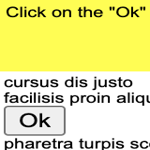

In [5]:
states[0].screenshot.resize([150, 150])

In [6]:
img = pil_to_numpy_array(states[0].screenshot)
img.shape

(210, 160, 3)

In [7]:
states[0].dom.visualize()

"- [1] body @ (0, 0) classes=[NO_CLASS] children=1\n  |- [2] div @ (0, 0) classes=[NO_CLASS] children=1\n     |- [3] div @ (0, 50) classes=[NO_CLASS] children=6\n        |- [4] div @ (2, 52) text='cursus dis justo' classes=[NO_CLASS]\n        |- [5] div @ (2, 63) text='facilisis proin aliq...' classes=[NO_CLASS]\n        |- [6] button @ (2, 74) text='Ok' classes=[NO_CLASS]\n        |- [7] div @ (2, 95) text='pharetra turpis scel...' classes=[NO_CLASS]\n        |- [8] div @ (2, 106) text='rutrum lectus adipis...' classes=[NO_CLASS]\n        |- [9] div @ (2, 117) text='pretium, aliquet ege...' classes=[NO_CLASS]"

In [8]:
states[0].tokens

['Click', 'on', 'the', '"', 'Ok', '"', 'button', '.']

In [10]:
env.close()

# Gym miniwob wrapper

In [749]:
import gym
import torch
import numpy as np

from miniwob.action import MiniWoBElementClick, MiniWoBCoordClick
from transformers import BertTokenizer, BertModel, BertConfig


class MiniWobClickButtonWrapper(gym.Wrapper):
    
    def __init__(self, env):      
        super().__init__(env)
        self.env = env
        bert_model = 'bert-base-cased'
        self.tokenizer = BertTokenizer.from_pretrained(bert_model)
        
        self.observation_space = gym.spaces.Dict({"goal_state": gym.spaces.Box(0, 
                                                                              self.tokenizer.vocab_size, (8, ),
                                                                              dtype=np.int64), 
                                                 "state": gym.spaces.Box(0, 255, (150, 150, 3), dtype=np.uint8)})
        

        self.h, self.w = 210, 160
        self.grid_step = 10
        n_actions = int(self.h/self.grid_step+1) * int(self.w/self.grid_step+1)
        self.action_space = gym.spaces.Discrete(n_actions)
        
    def _ob_to_token(self, ob):
        max_length = 8
        if ob is None:
            return torch.zeros(1, max_length)
        else: 
            return self.tokenizer(ob.tokens,  
                                  padding='max_length', 
                                  max_length = max_length, truncation=True,          
                                  return_tensors="pt",
                                  is_split_into_words=True)['input_ids']
            
    def _ob_to_image(self, ob):
        if ob is None:
            return torch.zeros(1, 150, 150, 3)
        else:
            return torch.tensor(pil_to_numpy_array(ob.screenshot.resize([150, 150]))).unsqueeze(0)
        
    
    def _to_miniwob_actions(self, actions):
        
        n_x = int(self.w/self.grid_step + 1)        
        actions = actions.squeeze()
        miniwob_actions = []
        
        for i in range(self.num_instances):
            if self.instances[i].get_metadata()['done']:
                miniwob_actions.append(None)
            else:
                k = actions[i].item()
                x, y = k%n_x * self.grid_step, int(k/n_x) * self.grid_step
                miniwob_actions.append(MiniWoBCoordClick(x, y))
        return miniwob_actions
        
    
    def observation(self, obs):
            
        goals = torch.cat([self._ob_to_token(ob) for ob in obs], dim=0)
        imgs = torch.cat([self._ob_to_image(ob) for ob in obs], dim=0)
        doms = ["" for ob in obs] # ob.dom.visualize()
        return {'state': imgs, 'dom': doms, 'goal_state': goals}
    
    def reset(self):
        return self.observation(self.env.reset(record_screenshots=True))
    
            
    
    def step(self, actions):
        
        miniwob_actions = self._to_miniwob_actions(actions)
        obs, rewards, dones, infos = self.env.step(miniwob_actions)        
        obs = self.observation(obs)
        
        for instance in self.env.instances:
            if instance.get_metadata()['done']:
                instance.begin_task()
        
        return obs, torch.tensor([rewards]).T, torch.tensor([dones]).T, infos['n']
        
class EpisodeInfoWrapper(gym.Wrapper):
    
    def __init__(self, env, n):
        super(EpisodeInfoWrapper, self).__init__(env)
        self.episode_reward = np.zeros(n)
        self.episode_steps = np.zeros(n)
        self.n = n

    def reset(self):
        self.episode_reward = np.zeros(self.n)
        self.episode_steps = np.zeros(self.n)
        return self.env.reset()

    def step(self, actions):
        states, rewards, dones, infos = self.env.step(actions)
        
        for i, done in enumerate(dones):
            if done:
                self.episode_reward[i] = rewards[i]
                self.episode_steps[i] += 1
                infos[i]['episode'] = {'r': self.episode_reward[i], 'steps': self.episode_steps[i]}
                
        return states, rewards, dones, infos

In [750]:
def get_envs(n, **kwargs):
    env = MiniWoBEnvironment(task_name, seeds=range(n), num_instances=n, base_url=base_url, **kwargs)
    env = MiniWobClickButtonWrapper(env)
    return EpisodeInfoWrapper(env, n)

In [751]:
from rllr.models.encoders import GoalStateEncoder, SimpleCNN

conf = {
    "n_channels": [32, 64, 64],
    "kernel_sizes": [4, 4, 3],
    "strides": [4, 2, 1],
    "hidden_layers_sizes": [128]
}

state_encoder = SimpleCNN(grid_size=150, conf=conf)
goal_encoder = BertEncoder()
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Bert encoder

In [752]:
from transformers import BertTokenizer, BertModel, BertConfig
from torch import nn
import torch

class BertEncoder(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        bert_model = 'bert-base-cased'
        self.bert_encoder = BertModel.from_pretrained(bert_model)
        self.embed_dim = 768
        self.output_size = 100
        self.lstm = nn.LSTM(input_size=self.embed_dim, 
                            hidden_size=self.output_size, 
                            num_layers=2)
        
   
    def forward(self, input_ids):
        """
        Encode batch of tokens
        
        """
        with torch.no_grad():
            embeds = self.bert_encoder(input_ids.long()).last_hidden_state
        embeds = embeds.permute([1, 0, 2])
            
        output, _ = self.lstm(embeds)
        return output[-1]

# Train agent

In [753]:
from rllr.models.encoders import GoalStateEncoder, SimpleCNN

conf = {
    "n_channels": [32, 64, 64],
    "kernel_sizes": [4, 4, 3],
    "strides": [4, 2, 1],
    "hidden_layers_sizes": [128]
}

state_encoder = SimpleCNN(grid_size=150, conf=conf)
goal_encoder = BertEncoder()
encoder = GoalStateEncoder(state_encoder, goal_encoder)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [759]:
n_instances = 8
envs = get_envs(n_instances, headless=True)

In [760]:
from rllr.algo import PPO
from rllr.models.ppo import ActorCriticNetwork

hidden_size = 32
policy = ActorCriticNetwork(envs.action_space, encoder, encoder, hidden_size, hidden_size)

agent_conf = {
        "clip_param": 0.2,
        "ppo_epoch": 4,
        "num_mini_batch": 4,
        "value_loss_coef": 0.5,
        "entropy_coef": 0.01,
        "lr": 0.001,
        "eps": 1e-5,
        "max_grad_norm": 0.5,
}


agent = PPO(policy, **agent_conf)

In [ ]:
from rllr.utils.training import train_ppo

train_conf = {
    "agent.lr": 0.001,
    "agent.device": "cpu",
    "agent.gamma": 0.99,
    "agent.gae_lambda": 0.95,
    "training.n_env_steps": 20000,
    "training.n_steps": 50,
    "training.n_processes": n_instances,
    "training.verbose": 5,
    "outputs.path": "minigrid_worker.p"
}


train_ppo(envs, agent, train_conf)

  0%|          | 0/50 [00:00<?, ?it/s]WARNING:root:Cannot call CoordClick(coords: (30, 70)) on instance 1, which is already done


Updates 0, num timesteps 400, FPS 4 
Last 10 training episodes: mean/median reward -0.71/-1.00, min/max reward -1.00/0.60
dist_entropy 5.92, value_loss 0.10, action_loss -0.02


 10%|█         | 5/50 [07:51<1:10:11, 93.60s/it]

Updates 5, num timesteps 2400, FPS 4 
Last 10 training episodes: mean/median reward -0.71/-1.00, min/max reward -1.00/0.59
dist_entropy 5.82, value_loss 0.06, action_loss -0.02


 14%|█▍        | 7/50 [10:58<1:06:51, 93.29s/it]